# QCoDeS Example with the Rigol DS 1074 Z oscilloscope

This notebook presents the implementation of QCoDeS driver for the Rigol DS1074Z oscilloscope.

## Importing dependencies 

In [16]:
import visa

#Qcodes import
from qcodes.dataset.plotting import plot_dataset
from qcodes.instrument_drivers.rigol import DS1074Z
from qcodes.instrument.parameter import expand_setpoints_helper
from qcodes import initialise_database, load_or_create_experiment, Measurement

## Create the instrument 

The address of the oscilloscope is needed to create the instrument. The address can also be found using the NI-MAX explorer.

The instrument is created in the following way: 

In [2]:
rigol = DS1074Z.RigolDrivers('rigol', 'USB0::0x1AB1::0x04CE::DS1ZB161650342::INSTR')

In [3]:
rigol.connect_message()

Connected to: RIGOL TECHNOLOGIES DS1074Z (serial:DS1ZB161650342, firmware:00.04.00) in 1.26s


## Prepare trace

In this example we choose channel 1 (ch1) to obtain the trace. We first prepare the oscilloscope to return the values of raw trace.

In [5]:
rigol.channels.ch1.get_trace.prepare_curvedata()

## Trigger setup  

Trigger source can be set to any channel (1 to 4). Here we use the input signal from channel 1 itself as a source for trigger. 

In [6]:
rigol.trigger_edge_source('CHANnel1')
rigol.trigger_edge_slope('negative')

The trigger-mode type supported by this oscilloscope are `EDGe,PULSe, SLOPe, VIDeo, PATTern, DURATion`. Both the trigger mode and trigger level can be set in the following manner. 

In [7]:
rigol.trigger_mode('PULS')
rigol.trigger_level(0.1)

## Data acquisition and plotting

The data acquisition is performed using measurement context manager. After initializing the database and loading/creating the experiment, the parameters are registered. The result are added to the database via datasaver object. The plot can be easily obtained using ``plot_by_id``.

Here, we show two ways of data acquisition. First, where setpoint is defined upfront (while registering the parameter and second, where a helper function is used to acquire both the oscilloscope trace and its setpoint. 

In [8]:
initialise_database()
exp = load_or_create_experiment(experiment_name='Oscilloscope trace',
                               sample_name='no_name')

Upgrading database: : 0it [00:00, ?it/s]
Upgrading database: : 0it [00:00, ?it/s]
Upgrading database, version 5 -> 6: : 0it [00:00, ?it/s]


In [12]:
meas = Measurement()
trace = rigol.channels.ch1.get_trace
time = rigol.time_axis
meas.register_parameter(time)
meas.register_parameter(trace, setpoints=(time,))

with meas.run() as datasaver:
        trace_val = trace()
        time_val = time()
        datasaver.add_result((time, time_val),
                             (trace, trace_val))


Starting experimental run with id: 2


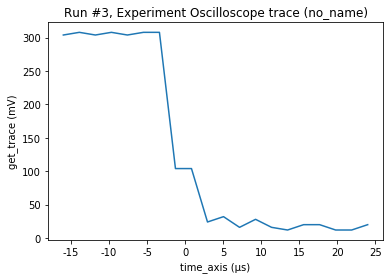

In [26]:
_ = plot_dataset(datasaver.dataset)

Now, the same measurement can also be performed using a helper function `expand_setpoints_helper`. This function takes a ParameterWithSetpoints and acquires the parameter along with it's setpoints. The data is returned in a format prepared to insert into the dataset. Parameter `get_trace` is a ParameterWithSetpoints. 

In [23]:
meas_helper = Measurement()
meas_helper.register_parameter(rigol.channels.ch1.get_trace)

with meas_helper.run() as datasaver:
        trace_val = trace()
        time_val = time()
        datasaver.add_result(*expand_setpoints_helper(rigol.channels.ch1.get_trace))

Starting experimental run with id: 3


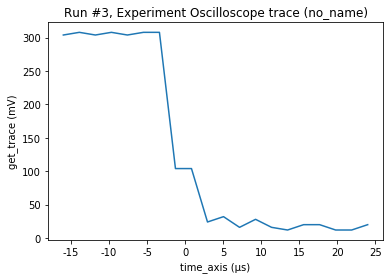

In [27]:
_ = plot_dataset(datasaver.dataset)